In [71]:
import sys
from os import listdir
import os

from xml.dom.minidom import parse

import pandas as pd
import numpy as np

import nltk
from nltk import tokenize

import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing


print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.2.5.
The scikit-learn version is 0.20.1.


In [129]:
medline_dir = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Train/MedLine/"
drugbank_dir = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Train/DrugBank/"

In [130]:
medline_test_dir = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Test-NER/MedLine/"
drugbank_test_dir = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Test-NER/DrugBank/"

# Load data

In [95]:
def parse_XML_file(datadir):
    trees = []
    for f in listdir(datadir):
        # parse XML file
        tree = parse(datadir + "/" + f)
        trees.append(tree)
    return trees

def parsed_to_df(parsed):
    items = []
    for tree in parsed:
        for s in tree.getElementsByTagName("sentence"):
            s_id = s.attributes["id"].value
            s_txt = s.attributes["text"].value            
            
            e_names = []
            for e in s.getElementsByTagName("entity"):
                e_name = e.attributes["text"].value
                e_type = e.attributes["type"].value
                e_offset = e.attributes["charOffset"].value
                item = {"s_id": s_id, "e_name": e_name, "e_type": e_type, "e_offset": e_offset}
                e_names.append(e_name)
                items.append(item)
                
            tkns = nltk.word_tokenize(s_txt)
            for tkn in tkns:
                if tkn not in e_names: # not robust
                    start = s_txt.find(tkn) 
                    end = start + len(tkn) - 1
                    e_offset = str(start)+"-"+str(end)
                    item = {"s_id": s_id, "e_name": tkn, "e_type": "not_drug", "e_offset": e_offset}
                    items.append(item)
                
    return pd.DataFrame(items)

def load_data(datadir):
    trees = parse_XML_file(datadir)
    df_loaded = parsed_to_df(trees)
    return df_loaded

In [96]:
df_drugbank = load_data(drugbank_dir)
df_drugbank.shape

(120594, 4)

In [97]:
df_medline = load_data(medline_dir)
df_medline.shape

(30071, 4)

In [98]:
df = df_drugbank.append(df_medline, ignore_index=True)
df.shape

(150665, 4)

In [99]:
df.head()

,e_name,e_offset,e_type,s_id
0,calcium,25-31,drug,DDI-DrugBank.d481.s0
1,EMCYT,82-86,brand,DDI-DrugBank.d481.s0
2,Milk,0-3,not_drug,DDI-DrugBank.d481.s0
3,",",4-4,not_drug,DDI-DrugBank.d481.s0
4,milk,6-9,not_drug,DDI-DrugBank.d481.s0


# Features

In [101]:
def extract_features(input_df):
    input_df['e_is_title'] = input_df['e_name'].apply(lambda x : x.istitle())
    input_df['e_is_upper'] = input_df['e_name'].apply(lambda x : x.isupper())
    input_df['e_suffix'] = input_df['e_name'].apply(lambda x : x[-5:])
    input_df['e_plural'] = input_df['e_name'].apply(lambda x : x[-1:] == 's')
    input_df['e_pos'] = input_df['e_name'].apply(lambda x : nltk.pos_tag([x])[0][1])
    input_df['e_is_digit'] = input_df['e_name'].apply(lambda x : x.isdigit())

In [102]:
extract_features(df)
df.head()

,e_name,e_offset,e_type,s_id,e_is_title,e_is_upper,e_suffix,e_plural,e_pos,e_is_digit
0,calcium,25-31,drug,DDI-DrugBank.d481.s0,False,False,lcium,False,NN,False
1,EMCYT,82-86,brand,DDI-DrugBank.d481.s0,False,True,EMCYT,False,NN,False
2,Milk,0-3,not_drug,DDI-DrugBank.d481.s0,True,False,Milk,False,NN,False
3,",",4-4,not_drug,DDI-DrugBank.d481.s0,False,False,",",False,",",False
4,milk,6-9,not_drug,DDI-DrugBank.d481.s0,False,False,milk,False,NN,False


# Input data

In [103]:
label = 'e_type'
features = ['e_is_title','e_is_upper', 'e_suffix', 'e_plural', 'e_pos', 'e_is_digit']

In [104]:
def get_input(input_df, label_col, features_cols):
    Ys = np.array(input_df[label_col])
    Xs = np.array(input_df[features_cols])
    return (Xs, Ys)

In [105]:
(X, Y) = get_input(df, label, features)
print(Y.shape, X.shape)
print(Y[:5])
print(X[:5])

(150665,) (150665, 6)
['drug' 'brand' 'not_drug' 'not_drug' 'not_drug']
[[False False 'lcium' False 'NN' False]
 [False True 'EMCYT' False 'NN' False]
 [True False 'Milk' False 'NN' False]
 [False False ',' False ',' False]
 [False False 'milk' False 'NN' False]]


In [106]:
def encode_labels(Ys):
    le_Ys = preprocessing.LabelEncoder()
    le_Ys.fit(Ys)
    Ys_enc = le_Ys.transform(Ys)
    return (Ys_enc, le_Ys)

In [107]:
(Y_enc, le) = encode_labels(Y)
print("Classes:",le.classes_)
print(Y[0:5])
print(Y_enc[0:5])
print(Y_enc.shape)

Classes: ['brand' 'drug' 'drug_n' 'group' 'not_drug']
['drug' 'brand' 'not_drug' 'not_drug' 'not_drug']
[1 0 4 4 4]
(150665,)


In [108]:
def encode_features(Xs):
    enc_Xs = preprocessing.OneHotEncoder(handle_unknown="ignore")
    enc_Xs.fit(Xs)
    Xs_enc = enc.transform(Xs)
    return (Xs_enc, enc_Xs)

In [109]:
(X_enc, enc) = encode_features(X)
print("Categories:",enc.categories_)
print(X[0])
print(X_enc[0].toarray())
print(X_enc.shape)

Categories: [array([False, True], dtype=object), array([False, True], dtype=object), array([' Acid', ' B-12', ' Drug', ..., 'zymes', '~40', '~47'],
      dtype=object), array([False, True], dtype=object), array(['#', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'IN',
       'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNS', 'POS', 'PRP', 'PRP$',
       'RB', 'RBR', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP',
       'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``'], dtype=object), array([False, True], dtype=object)]
[False False 'lcium' False 'NN' False]
[[1. 0. 1. ... 0. 1. 0.]]
(150665, 5872)


# Model

In [110]:
from sklearn.tree import DecisionTreeClassifier

In [111]:
clf = DecisionTreeClassifier(random_state= 42)
clf = clf.fit(X_enc, Y_enc)

## Classification

In [112]:
df_medline_test = load_data(medline_test_dir)
df_drug_bank_test = load_data(drugbank_test_dir)

In [113]:
df_test = df_medline_test

In [114]:
extract_features(df_test)
df_test.head()

,e_name,e_offset,e_type,s_id,e_is_title,e_is_upper,e_suffix,e_plural,e_pos,e_is_digit
0,antidepressants,54-68,group,DDI-MedLine.d203.s0,False,False,sants,True,NNS,False
1,Potential,0-8,not_drug,DDI-MedLine.d203.s0,True,False,ntial,False,JJ,False
2,underuse,10-17,not_drug,DDI-MedLine.d203.s0,False,False,eruse,False,NN,False
3,",",18-18,not_drug,DDI-MedLine.d203.s0,False,False,",",False,",",False
4,overuse,20-26,not_drug,DDI-MedLine.d203.s0,False,False,eruse,False,NN,False


In [115]:
(X_test,Y_test)=get_input(df_test, label, features)
print(Y_test.shape, X_test.shape)

(12047,) (12047, 6)


In [116]:
Y_test_enc = le.transform(Y_test)
X_test_enc = enc.transform(X_test)
print(Y_test_enc.shape, X_test_enc.shape)

(12047,) (12047, 5872)


In [117]:
Y_pred = clf.predict(X_test_enc)

In [118]:
clf.score(X_test_enc, Y_test_enc)

0.9725242799037105

### Confusion matrix

In [119]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [120]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


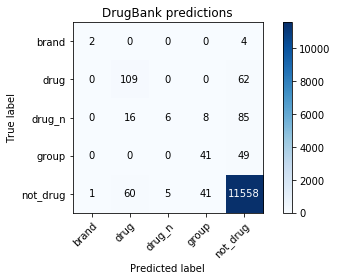

In [121]:
# Plot non-normalized confusion matrix
class_names = le.classes_
plot_confusion_matrix(Y_test_enc, Y_pred, classes=class_names, title="DrugBank predictions")
plt.show()

In [122]:
df_test[['e_name', 'e_type']].groupby(['e_type']).count()

,e_name
e_type,
brand,6
drug,171
drug_n,115
group,90
not_drug,11665


## Detection and classification

In [138]:
def parsed_sentence_to_df(parsed):
    items = []
    for tree in parsed:
        for s in tree.getElementsByTagName("sentence"):
            s_id = s.attributes["id"].value
            s_txt = s.attributes["text"].value            
                
            tkns = nltk.word_tokenize(s_txt)
            for tkn in tkns:
                    start = s_txt.find(tkn) 
                    end = start + len(tkn) - 1
                    e_offset = str(start)+"-"+str(end)
                    item = {"s_id": s_id, "e_name": tkn, "e_offset": e_offset}
                    items.append(item)
                
    return pd.DataFrame(items)

def load_unlabeled_data(datadir):
    trees = parse_XML_file(datadir)
    df_loaded = parsed_sentence_to_df(trees)
    return df_loaded

In [159]:
data = load_unlabeled_data(drugbank_test_dir)
extract_features(data)
data.head()

,e_name,e_offset,s_id,e_is_title,e_is_upper,e_suffix,e_plural,e_pos,e_is_digit
0,There,0-4,DDI-DrugBank.d683.s0,True,False,There,False,EX,False
1,are,6-8,DDI-DrugBank.d683.s0,False,False,are,False,VBP,False
2,",",9-9,DDI-DrugBank.d683.s0,False,False,",",False,",",False
3,as,11-12,DDI-DrugBank.d683.s0,False,False,as,True,IN,False
4,yet,14-16,DDI-DrugBank.d683.s0,False,False,yet,False,RB,False


In [160]:
with open("task9.1_TREE1_medline_1.txt", "w") as text_file:
    for index, row in data.iterrows():
        X = np.array(row[3:])
        encoded = enc.transform([X])
        prediction = clf.predict(encoded)
        label = le.inverse_transform(prediction)[0]
        if label != "not_drug":
            print(row["s_id"], row["e_offset"], row["e_name"], label, sep="|", file=text_file)